# Smith-Waterman genome application

We will apply the Smith-Waterman algorithm to two specific sequences. In this example, we align the NC_000017.11 Seq 1 scaffold with the whole gorilla genome.

In [1]:
import pandas as pd
import time
import numpy as np
from datetime import datetime as dt

In [71]:
# -*- coding: utf-8 -*-

"""

LIFE97011 - Computing
Python Programming - Assessed Exercise No. 3
Task: Smith Waterman local alignment
@Author: Slaviana Pavlovich

"""

# Importing Python packages
from enum import IntEnum
import numpy as np

# Assigning the constants for the scores
class Score(IntEnum):
    # order by value it should be
    MATCH = 10      
    CONS_GAP = -1   # Want to penalize worst a first gap than a secong gap
    FIRST_GAP = -4
    MISMATCH = -5
    #INV = 0

# Match: 10 , First_gap: -4, cons_gap: -1, mismatch: -5

# Assigning the constant values for the traceback
class Trace(IntEnum):
    STOP = 0
    LEFT = 1 
    UP = 2
    DIAGONAL = 3

def excel_reader(specie):
    data = pd.read_excel('../Data/Raw/Tables_Filtered_IK.xlsx', specie)
    
    data['Gene'] = data['Locus'].str.split('(\d+)').str[0] + data['Strand']
    data['Gene_non_or'] = data['Locus'].str.split('(\d+)').str[0]
    data.reset_index(inplace= True)

    data = data[data['Gene'].str.contains('LOC') == False]  

    return data

# Implementing the Smith Waterman local alignment
def smith_waterman(seq_1, seq_2):

    # Data structure:
    # 0: index
    # 1: gen + orientation
    # 2: gen

    row = len(seq_1) + 1
    col = len(seq_2) + 1
    matrix = np.zeros(shape=(row, col), dtype= int)  
    tracing_matrix = np.zeros(shape=(row, col), dtype= int)  

    # Initialising the variables to find the highest scoring cell
    max_score = -1
    max_index = (-1, -1)

    diagonal_score = 0
    vertical_score = 0
    horizontal_score = 0
    
    # Calculating the scores for all cells in the matrix

    for i in range(1, row):
        for j in range(1, col):
            
            # Calculating the diagonal score (match score)
            match_value = Score.MATCH if seq_1.iloc[i - 1, 2] == seq_2.iloc[j - 1, 2] else Score.MISMATCH
                #Score.INV if seq_1.iloc[i - 1, 2] == seq_2.iloc[j - 1, 2] else  --> No sense, it will make sense if the overall is inversed and then one of them is turned around. So, first, check the overall waz and then compare them.
                
            diagonal_score = matrix[i - 1, j - 1] + match_value

            # Calculating the vertical gap score, penalizing consecutive gaps
            if matrix[i - 1, j] == vertical_score:
                vertical_score = matrix[i - 1, j] + Score.CONS_GAP
            else: vertical_score = matrix[i - 1, j] + Score.FIRST_GAP
            
            # Calculating the vertical gap score, penalizing consecutive gaps
            if matrix[i, j - 1] == horizontal_score:
                horizontal_score = matrix[i, j - 1] + Score.CONS_GAP
            else: horizontal_score = matrix[i, j - 1] + Score.FIRST_GAP
            
            # Taking the highest score 
            matrix[i, j] = max(0, diagonal_score, vertical_score, horizontal_score)
            
            # Tracking where the cell's value is coming from    
            if matrix[i, j] == 0: 
                tracing_matrix[i, j] = Trace.STOP
                
            elif matrix[i, j] == horizontal_score: 
                tracing_matrix[i, j] = Trace.LEFT
                
            elif matrix[i, j] == vertical_score: 
                tracing_matrix[i, j] = Trace.UP
                
            elif matrix[i, j] == diagonal_score: 
                tracing_matrix[i, j] = Trace.DIAGONAL 
                
            # Tracking the cell with the maximum score
            # If we want different strings, here we can define a threshold and keep track of all the higher values
            if matrix[i, j] >= max_score:
                max_index = (i,j)
                max_score = matrix[i, j]


    # Initialising the variables for tracing
    aligned_seq_1 = [ ]
    aligned_seq_2 = [ ]
    index_seq_1 = [ ]
    index_seq_2 = [ ]
    (max_i, max_j) = max_index

    # Tracing and computing the pathway with the local alignment
    #if max_score > 3 * Score.MATCH
    while tracing_matrix[max_i, max_j] != Trace.STOP:
        if tracing_matrix[max_i, max_j] == Trace.DIAGONAL:
            aligned_seq_1.insert(0, seq_1.iloc[max_i - 1, 2])
            aligned_seq_2.insert(0, seq_2.iloc[max_j - 1, 2])

            index_seq_1.insert(0, seq_1.iloc[max_i - 1, 0])
            index_seq_2.insert(0, seq_2.iloc[max_j - 1, 0])

            max_i = max_i - 1
            max_j = max_j - 1
            

        elif tracing_matrix[max_i, max_j] == Trace.UP:
            aligned_seq_1.insert(0, seq_1.iloc[max_i - 1, 2])
            aligned_seq_2.insert(0, '-')

            index_seq_1.insert(0, seq_1.iloc[max_i - 1, 0])
            index_seq_2.insert(0, '-')

            max_i = max_i - 1    
            

        elif tracing_matrix[max_i, max_j] == Trace.LEFT:
            aligned_seq_1.insert(0, '-')
            aligned_seq_2.insert(0, seq_2.iloc[max_j - 1, 2])

            index_seq_1.insert(0, '-')
            index_seq_2.insert(0, seq_2.iloc[max_j - 1, 0])
            
            max_j = max_j - 1

    return aligned_seq_1, aligned_seq_2, index_seq_1, index_seq_2, max_score, max_index, max_i, max_j, matrix

def duplicate(all):
    for i in range(1, len(all)):
        if all.loc[i, 'Result'] == 'Gap':
            if (all.loc[i-1, 'Result'] == 'Match') | (all.loc[i-1, 'Result'] == 'Inversion'):
                if (all.loc[i-1,'Seq 1 Gene'] == all.loc[i,'Seq 1 Gene']) | (all.loc[i-1,'Seq 2 Gene'] == all.loc[i,'Seq 2 Gene']):
                    all.loc[i, 'Result'] = 'Duplicate'

                    # Check for consecutives duplicates
                    j = i+1
                    while((j<len(all)) & (all.loc[j, 'Result'] == 'Gap') & (all.loc[i,'Seq 1 Gene'] == all.loc[j,'Seq 1 Gene']) & (all.loc[i,'Seq 2 Gene'] == all.loc[j,'Seq 2 Gene'])):
                        all.loc[j, 'Result'] = 'Duplicate'
                        j+=1
                    i=j-1
    return all

def merge(seq_1, seq_2, aligned_seq_1, index_seq_1, aligned_seq_2, index_seq_2):
    align_seq_1 = pd.DataFrame({'Original Position' : index_seq_1, 'Gene': aligned_seq_1}).merge(seq_1[['index', '#Replicon Name', 'Replicon Accession', 'Strand']], left_on = 'Original Position', right_on = 'index', how = 'left')
    align_seq_2 = pd.DataFrame({'Original Position' : index_seq_2, 'Gene': aligned_seq_2}).merge(seq_2[['index', '#Replicon Name', 'Replicon Accession', 'Strand']], left_on = 'Original Position', right_on = 'index', how = 'left')

    align_seq_1.rename(columns={'Original Position': 'Seq 1 Original Position', 'Gene' : 'Seq 1 Gene', '#Replicon Name': 'Seq 1 Replicon Name', 'Replicon Accession' : 'Seq 1 Replicon Accession', 'Strand': 'Seq 1 Orientation'}, inplace = True)
    align_seq_2.rename(columns={'Original Position': 'Seq 2 Original Position', 'Gene' : 'Seq 2 Gene', '#Replicon Name': 'Seq 2 Replicon Name', 'Replicon Accession' : 'Seq 2 Replicon Accession', 'Strand': 'Seq 2 Orientation'}, inplace = True)

    all = align_seq_1.loc[:, align_seq_1.columns != 'index'].merge(align_seq_2.loc[:, align_seq_2.columns != 'index'], right_index = True, left_index = True)

    all['Result'] = np.where(all['Seq 1 Gene'] == all['Seq 2 Gene'],  
                    np.where(all['Seq 1 Orientation'] == all['Seq 2 Orientation'], 'Match', 'Inversion'),
                    np.where(((all['Seq 1 Gene'] == '-') | (all['Seq 2 Gene'] == '-')),
                      'Gap', 'Mismatch'))
    
    all = all.reindex(
            columns = ['Seq 1 Original Position', 'Seq 1 Replicon Name',
            'Seq 1 Replicon Accession', 'Seq 1 Orientation', 'Seq 1 Gene', 'Result', 'Seq 2 Gene', 'Seq 2 Orientation',
            'Seq 2 Replicon Accession', 'Seq 2 Replicon Name', 'Seq 2 Original Position'])

    return all


In [3]:
human = excel_reader('Human')
gorilla = excel_reader('Gorilla')

In [4]:
human['Replicon Accession'].unique()

array(['NT_113891.3', 'NT_113949.2', 'NT_167244.2', 'NT_167245.2',
       'NT_167246.2', 'NT_167247.2', 'NT_167248.2', 'NT_167249.2',
       'NT_167250.2', 'NT_167251.2', 'NT_187368.1', 'NT_187515.1',
       'NT_187516.1', 'NT_187517.1', 'NT_187518.1', 'NT_187519.1',
       'NT_187520.1', 'NT_187522.1', 'NT_187526.1', 'NT_187527.1',
       'NT_187528.1', 'NT_187529.1', 'NT_187532.1', 'NT_187533.1',
       'NT_187534.1', 'NT_187539.1', 'NT_187540.1', 'NT_187546.1',
       'NT_187547.1', 'NT_187548.1', 'NT_187550.1', 'NT_187551.1',
       'NT_187552.1', 'NT_187553.1', 'NT_187556.1', 'NT_187558.1',
       'NT_187559.1', 'NT_187561.1', 'NT_187562.1', 'NT_187564.1',
       'NT_187565.1', 'NT_187569.1', 'NT_187570.1', 'NT_187571.1',
       'NT_187573.1', 'NT_187574.1', 'NT_187576.1', 'NT_187577.1',
       'NT_187578.1', 'NT_187580.1', 'NT_187583.1', 'NT_187584.1',
       'NT_187585.1', 'NT_187586.1', 'NT_187587.1', 'NT_187588.1',
       'NT_187589.1', 'NT_187590.1', 'NT_187592.1', 'NT_187593

In [5]:
'''
# To load all of them at once and afterwards accessing one by one, this might be an option.
#https://towardsdatascience.com/a-simple-trick-to-load-multiple-excel-worksheets-in-pandas-3fae4124345b
# Define filepath
filepath = 'C:/Users/bertr/LRZ Sync+Share/Syntheny-Graph (Pirmin Schlicke)/Tables_Filtered_IK.xlsx'

# Load Excel file using Pandas with `sheet_name=None`
df_dict = pd.read_excel(filepath, sheet_name=None)

# Preview
df_dict

# Get a specific one
human = df_dict.get('Human')
'''

"\n# To load all of them at once and afterwards accessing one by one, this might be an option.\n#https://towardsdatascience.com/a-simple-trick-to-load-multiple-excel-worksheets-in-pandas-3fae4124345b\n# Define filepath\nfilepath = 'C:/Users/bertr/LRZ Sync+Share/Syntheny-Graph (Pirmin Schlicke)/Tables_Filtered_IK.xlsx'\n\n# Load Excel file using Pandas with `sheet_name=None`\ndf_dict = pd.read_excel(filepath, sheet_name=None)\n\n# Preview\ndf_dict\n\n# Get a specific one\nhuman = df_dict.get('Human')\n"

### Smith-Waterman  
Prepare a dataset to implement S-W algorithm. For doing so, we will try to implement a small one, comparing two random scaffolds from human and gorilla.

In [6]:
accession = 'NC_000002.12'
sw_human = human.loc[human['Replicon Accession'].str.contains(accession), ['index', 'Gene', 'Gene_non_or']]
#sw_human = human.loc[human['Replicon Accession'].str.contains('NC_000020.11'), ['Gene', '#Replicon Name', 'Replicon Accession']] # length: 611
#sw_gorilla = gorilla.loc[gorilla['Replicon Accession'].str.contains('NC_018435.2'), ['index', 'Gene', 'Gene_non_or']]
#sw_gorilla_scaffold = gorilla.loc[gorilla['Replicon Accession'].str.contains('NC_018440.2'), 'Gene'] # length: 739
sw_gorilla = gorilla.loc[:,['index', 'Gene', 'Gene_non_or']]
#sw_human.to_csv('C:/Users/bertr/LRZ Sync+Share/Thesis/Data/Intermidiate/sw_human.csv')
#sw_gorilla.to_csv('C:/Users/bertr/LRZ Sync+Share/Thesis/Data/Intermidiate/sw_gorilla.csv')

In [31]:
seq_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17433 entries, 2 to 22043
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        17433 non-null  int64 
 1   Gene         17433 non-null  object
 2   Gene_non_or  17433 non-null  object
dtypes: int64(1), object(2)
memory usage: 544.8+ KB


In [42]:
seq_2.loc[(seq_2['index'] >= 2890) & (seq_2['index'] <=  4217)]

,index,Gene,Gene_non_or
2890,2890,MAL+,MAL
2891,2891,MRPS-,MRPS
2892,2892,ZNF-,ZNF
2893,2893,ZNF+,ZNF
2895,2895,PROM+,PROM
...,...,...,...
4213,4213,D+,D
4214,4214,GAL+,GAL
4215,4215,NEU+,NEU
4216,4216,PDCD-,PDCD


In [63]:
seq_2_reduced = pd.concat([seq_2.loc[(seq_2['index'] <= 2890), :], seq_2.loc[(seq_2['index'] >=  4217), :]])

In [65]:
seq_1_reduced = seq_1.loc[seq_1['index'] < 5640]

In [67]:
seq_1_reduced['index'].max()

5639

In [73]:
seq_1 = seq_1_reduced   #sw_human   
seq_1_name = 'human_' + accession
seq_2 =  seq_2_reduced  #sw_gorilla 
seq_2_name = 'gorilla_reduced'

# Executing the Smith Waterman local alignment algorithm
tic = time.perf_counter()
aligned_seq_1, aligned_seq_2, index_seq_1, index_seq_2, max_score, max_index, max_i, max_j, matrix = smith_waterman(seq_1, seq_2)
toc = time.perf_counter()


Modification of S-W to keep indexes

In [74]:
#print(f"Computed in {toc - tic:0.4f} seconds")
d = toc - tic
print('Computed in %s'%time.strftime('%H:%M:%S', time.gmtime(d)))

Computed in 00:15:11


In [75]:
all = merge(human, gorilla, aligned_seq_1, index_seq_1, aligned_seq_2, index_seq_2)

all = duplicate(all)

summary = pd.DataFrame({
    'Description' : ['Sequence 1', 'Length Sequence 1', 'Sequence 2', 'Length Sequence 2', 'Score', '', 'Aligned sequence 1 initial position', 'Aligned sequence 1 final position', 'Aligned sequence 1 length', '', 'Aligned sequence 2 initial position', 'Aligned sequence 2 final position', 'Aligned sequence 2 length'],
    'Value': [seq_1_name, len(seq_1), seq_2_name, len(seq_2), max_score, '', index_seq_1[0], index_seq_1[-1], index_seq_1[-1] - index_seq_1[0], '', index_seq_2[0], index_seq_2[-1], index_seq_2[-1] - index_seq_2[0]]
})

#Parameters
params = pd.DataFrame({
    'Description': ['', 'Parameters', 'Match', 'Mismatch', 'First gap', 'Second gap'], 
    'Value': ['', '', Score.MATCH, Score.MISMATCH, Score.FIRST_GAP, Score.CONS_GAP]})

summary = summary.append(params)

aligned_seq_1_df = pd.DataFrame(aligned_seq_1)
aligned_seq_2_df = pd.DataFrame(aligned_seq_2)

#KPIs
result_perc = all.groupby('Result')['Result'].count() / all.shape[0]
perc_align_seq_1 = aligned_seq_1_df[aligned_seq_1_df[0] != '-'].count()[0] / len(seq_1)
perc_align_seq_2 = aligned_seq_2_df[aligned_seq_2_df[0] != '-'].count()[0] / len(seq_2)


kpi = pd.DataFrame({
    'Description': ['','KPIs','% Covered Target sequence', '% Covered Query sequence', '% Matching', 'Number of consecutive genes'], #include where duplicates occur
    'Value': ['','', perc_align_seq_2, perc_align_seq_1, result_perc['Match'], len(all)]
})

summary = summary.append(kpi)

# Might be interesting to include the image of the aligned part

with pd.ExcelWriter('../Data/S_W_Intermediate/' + seq_1_name + '_' + seq_2_name + '_{}.xlsx'.format(dt.now().strftime('%Y%m%d_%H%M%S'))) as writer:
    summary.to_excel(writer, sheet_name = 'Summary', index = False, header=False)
    all.to_excel(writer, sheet_name = 'Comparison', index = False)


C:\Users\bertr\AppData\Local\Temp\ipykernel_3472\3184555009.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(params)
C:\Users\bertr\AppData\Local\Temp\ipykernel_3472\3184555009.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(kpi)


In [10]:
aligned_seq_1_df[aligned_seq_1_df[0] != '-'].count()[0]

876

In [11]:
len(seq_1)

1423

In [25]:
import torch

filter = torch.nn.MaxPool2d(kernel_size=3, stride=3, return_indices=True)
unpool = torch.nn.MaxUnpool2d(3, stride=3)
input = torch.tensor(matrix.astype(float)).unsqueeze(0)
output, indices = filter(input)
max_matrix = unpool(output, indices, output_size = np.shape(matrix)).squeeze()

In [13]:
max_matrix = pd.DataFrame(max_matrix.numpy())

In [14]:
max_matrix

,0,1,2,3,4,5,6,7,8,9,...,17424,17425,17426,17427,17428,17429,17430,17431,17432,17433
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
np.where(max_matrix > Score.MATCH)

(array([   2,    2,    2, ..., 1421, 1421, 1421], dtype=int64),
 array([ 345,  417, 2456, ..., 8292, 8295, 8298], dtype=int64))

Analyse the S-W matrix to see if there exist other alingments, in this case (human NC_000017.11 scaffold vs gorilla)

In [16]:
#matrix.tofile('S_W_Intermediate/matrix.csv', sep = ',')

Matrix to big to analyse element wise -> alternative, create a heatmap to see if there exist other regions where there are matches, i.e., exist positive values

<AxesSubplot:>

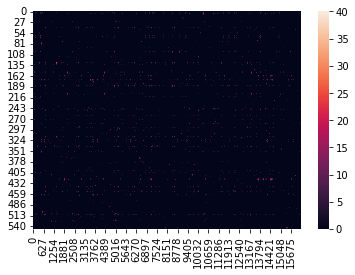

In [76]:
import seaborn as sns
sns.heatmap(matrix)

In [18]:
index_seq_1_filt = np.array(index_seq_1)[index_seq_1 != '-']
index_seq_2_filt = np.array(index_seq_1)[index_seq_2 != '-']

<AxesSubplot:>

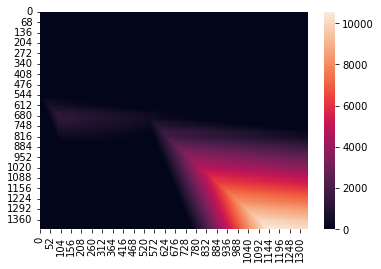

In [19]:
hm =matrix[:, max_j : max_index[1] + 200]
sns.heatmap(hm)

In [20]:
max_index[0]

1422

<AxesSubplot:>

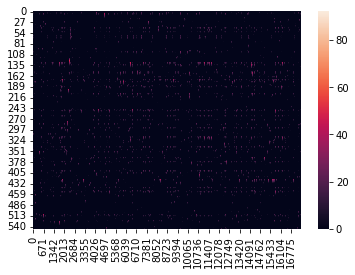

In [28]:
matrix_wout = matrix[:max_i, :]
sns.heatmap(matrix_wout)